### The EDA will analyse three scenarios:
    1. NDF
    2. US
    3. other

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

from scipy import stats as ss
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics 

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTETomek

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from keras import models as ml
from keras import layers as l

from scikitplot import metrics as mt

import random
from matplotlib import pyplot as plt
pd.set_option('mode.chained_assignment', None)

def load_data():
    df_raw = pd.read_csv('../data/train_users_2.csv', low_memory=True)
    df_sessions = pd.read_csv('../data/sessions.csv')
    return df_raw, df_sessions

def transform_data(df, df_sessions):
    #==================Training================

    #age
    age_mean = df['age'].mean()
    df['age'] = df['age'].fillna(age_mean)

    # first_affiliate_tracked
    df['first_affiliate_tracked'].dropna(inplace=True)

    #==================Sessions==============
    df_sessions.dropna(inplace = True)
    
    #date_account_created
    df['date_account_created'] = pd.to_datetime(df['date_account_created'])

    #timestamp_first_active
    df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')
    # date_first_booking - not available
    df.drop('date_first_booking', axis = 1, inplace = True)
    
    #age
    df['age'] = df['age'].astype('int64')
    
    #Filter
    df = df[(df['age']>15) & (df['age']<100)]
    
    return df, df_sessions

def feature_engineering(df, df_sessions):
    
    df['first_active'] = pd.to_datetime(df['timestamp_first_active'].dt.strftime('%Y-%m-%d'))

    #time between account created and first active
    df['days_from_active_to_account_created'] = (df['date_account_created'] - df['first_active']).dt.days

    #year  of first active
    df['year_first_active'] = df['first_active'].dt.year

    #month of first active
    df['month_first_active'] = df['first_active'].dt.month

    #day of first active
    df['day_first_active'] = df['first_active'].dt.day

    #day of week of first active
    df['day_of_week_first_active'] = df['first_active'].dt.dayofweek

    #week of year of first active
    df['week_of_year_first_active'] = df['first_active'].dt.isocalendar().week

    #year  of account created
    df['year_account_created'] = df['date_account_created'].dt.year

    #month of account created
    df['month_account_created'] = df['date_account_created'].dt.month

    #day of account created
    df['day_account_created'] = df['date_account_created'].dt.day

    #day of week of account created
    df['day_of_week_account_created'] = df['date_account_created'].dt.dayofweek

    #week of year of account created
    df['week_of_year_account_created'] = df['date_account_created'].dt.isocalendar().week

    # n_clicks
    n_clicks = df_sessions[df_sessions['action_type']=='click'].groupby('user_id').agg(n_clicks = ('user_id', 'count')).reset_index()
    df = pd.merge(df, n_clicks.rename(columns = {'user_id' : 'id'}), on ='id', how='left')
    df['n_clicks'].fillna(0, inplace=True)

    n_reviews = df_sessions[df_sessions['action']=='reviews'].groupby('user_id').agg(n_reviews = ('user_id', 'count')).reset_index()
    df = pd.merge(df, n_reviews.rename(columns = {'user_id' : 'id'}), on ='id', how='left')
    df['n_reviews'].fillna(0, inplace=True)
    
    return df

def data_preprocessing(df):

    # language to binary, either is english or not
    df['language_en'] = np.where(df['language']=='en', 1, 0)

    # signup to binary, either is web or not
    df['signup_on_web'] = np.where(df['signup_app']== 'Web', 1, 0)

    # first_affiliate_tracked to binary, either is tracked or not
    df['tracked'] = np.where(df['first_affiliate_tracked']=='untracked', 0, 1)

    #binary features from first_device_type
    df['first_device_apple'] = np.where(df['first_device_type'].isin(['Mac Desktop', 'iPhone', 'iPad']), 1 ,0)
    df['first_device_desktop'] = np.where(df['first_device_type'].isin(['Mac Desktop', 'Desktop', 'Windows Desktop']), 1, 0)

    # frequency encoding
    affiliate_channel_frequency_encoding = df['affiliate_channel'].value_counts(normalize=True)
    df['affiliate_channel'] = df['affiliate_channel'].map(affiliate_channel_frequency_encoding)

    affiliate_provider_frequency_encoding = df['affiliate_provider'].value_counts(normalize=True)
    df['affiliate_provider'] = df['affiliate_provider'].map(affiliate_provider_frequency_encoding)

    first_browser_frequency_encoding = df['first_browser'].value_counts(normalize=True)
    df['first_browser'] = df['first_browser'].map(first_browser_frequency_encoding)
    
    # Rescaling
    columns_to_rescale = [
    "age",
    "signup_flow",
    "n_reviews",
    "n_clicks"
    ]

    scaler = pp.MinMaxScaler()

    df[columns_to_rescale] = scaler.fit_transform(df[columns_to_rescale])
    
    # temporal columns 
    temporal_columns = [
    "days_from_active_to_account_created",
    "year_first_active",
    "month_first_active",
    "day_first_active",
    "day_of_week_first_active",
    "week_of_year_first_active",
    "year_account_created",
    "month_account_created",
    "day_account_created",
    "day_of_week_account_created",
    "week_of_year_account_created"]

     # month_account_created
    df['month_account_created_sin'] = df['month_account_created'].apply( lambda x: np.sin( x * (2*np.pi/12 ) ) )
    df['month_account_created_cos'] = df['month_account_created'].apply( lambda x: np.cos( x * (2*np.pi/12 ) ) )

    # week_account_created
    df['week_account_created_sin'] = df['week_of_year_account_created'].apply( lambda x: np.sin( x * (2*np.pi/52 ) ) )
    df['week_account_created_cos'] = df['week_of_year_account_created'].apply( lambda x: np.cos( x * (2*np.pi/52 ) ) )

    # day_account_created
    df['day_account_created_sin'] = df['day_account_created'].apply( lambda x: np.sin( x * (2*np.pi/30 ) ) )
    df['day_account_created_cos'] = df['day_account_created'].apply( lambda x: np.cos( x * (2*np.pi/30 ) ) )

    # day_of_week_account_created
    df['day_of_week_account_created_sin'] = df['day_of_week_account_created'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
    df['day_of_week_account_created_cos'] = df['day_of_week_account_created'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

    df.drop(temporal_columns, axis=1, inplace=True)
        
    cols_drop = [ 'gender', 'signup_method', 'language', 'first_affiliate_tracked',
           'signup_app', 'first_device_type','date_account_created', 'timestamp_first_active',
                  'first_active'] #original dates
    df = df.drop(cols_drop, axis=1)
    return df

def balance_data(X_imb, y_imb):
    
    majority_value = y.value_counts()[0]

    # Calcular os pesos de classe inversamente proporcionais à frequência
    class_weights = {'NDF': majority_value*1,
                     'US': int(majority_value*0.5),
                     'other': int(majority_value*0.18),
                     'FR': int(majority_value*0.15) ,
                     'IT': int(majority_value*0.13),
                     'GB': int(majority_value*0.13),
                     'ES': int(majority_value*0.13),
                     'CA': int(majority_value*0.13),
                     'DE': int(majority_value*0.13),
                     'NL': int(majority_value*0.09),
                     'AU': int(majority_value*0.09),
                     'PT': int(majority_value*0.09)
                    }

    # Instanciar o SMOTE com os pesos de classe definidos
    smote = BorderlineSMOTE(sampling_strategy=class_weights)

    # Aplicar o resampling usando o SMOTE
    X_resampled, y_resampled = smote.fit_resample(X, y)

    return X_resampled, y_resampled

def feature_importance(X,y):
    X_train, X_test, y_train, y_test = ms.train_test_split(X,y,test_size=0.2, random_state=32)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    importances = model.feature_importances_  # Obtendo as importâncias das features
    feature_names = list(df.columns) # Obtendo os nomes das features

    feature_importances = [(feature, importance) for feature, importance in zip(feature_names, importances)]
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

    sorted_features = [feature for feature, importance in feature_importances]
    sorted_importances = [importance for feature, importance in feature_importances]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
    plt.xticks(range(len(sorted_features)), sorted_features, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Converter classes categóricas para valores numéricos
    label_encoder = pp.LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    model.fit(X_train, y_train_encoded)
    yhat_encoded = model.predict(X_test)
    
    # Converter previsões numéricas de volta para a forma original
    yhat = label_encoder.inverse_transform(yhat_encoded)
    
    # Accuracy
    acc_random = metrics.accuracy_score(y_test, yhat)
    print(f'Accuracy score: {acc_random:.3f}')
    
    # Balanced accuracy
    balanced_acc_random = metrics.balanced_accuracy_score(y_test, yhat)
    print(f'Balanced accuracy score: {balanced_acc_random:.3f}')
    
    mt.plot_confusion_matrix(y_test, yhat, normalize=False, figsize=(10, 10), labels=label_encoder.classes_);

def get_model_metrics(model_trained, X_test, y_test):
    
    yhat = model_trained.predict(X_test)
    
    #balanced accuracy
    balanced_acc= metrics.balanced_accuracy_score(y_test, yhat)
 
    kappa_acc = metrics.cohen_kappa_score(y_test, yhat)
    
    return balanced_acc, kappa_acc


def cv(model, num_folds, X, y):
    kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    balanced_acc_list = []
    kappa_list = []
    x_train, x_test, y_train, y_test = ms.train_test_split(X, y, train_size=0.8)
    i= 1
    for train_ix, val_ix in kfold.split(x_train, y_train):
        print('Fold number {}'.format(i))
        #get fold
        x_train_fold = x_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        x_val_fold = x_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]

        model.fit(x_train_fold, y_train_fold)
        print(f'{i}/{num_folds}')
        
        balanced_acc, kappa = get_model_metrics(model, x_test, y_test)
        balanced_acc_list.append(balanced_acc)
        kappa_list.append(kappa)
        i+=1
    
    print(f'Balanced Accuracy CV = {np.mean(balanced_acc_list)}')
    print(f'Kappa Score CV = {np.mean(kappa_list)}')

## Separate data

In [6]:
df, df_sessions = load_data()

In [47]:
df['group'] = df['country_destination'].apply(lambda x: 'ndf' if x == 'NDF' else  'others')

In [48]:
a = pd.DataFrame(df['group'].value_counts())
b = pd.DataFrame(df['group'].value_counts(normalize = True))

pd.concat([a,b], axis= 1)

,group,group
ndf,124543,0.583473
others,88908,0.416527


## Time Analsys

In [49]:
#date_account_created
df['date_account_created'] = pd.to_datetime(df['date_account_created'])

#timestamp_first_active
df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')
df['first_active'] = pd.to_datetime(df['timestamp_first_active'].dt.strftime('%Y-%m-%d'))

#time between account created and first active
df['days_from_active_to_account_created'] = (df['date_account_created'] - df['first_active']).dt.days

#year  of first active
df['year_first_active'] = df['first_active'].dt.year

#month of first active
df['month_first_active'] = df['first_active'].dt.month

#day of first active
df['day_first_active'] = df['first_active'].dt.day

#day of week of first active
df['day_of_week_first_active'] = df['first_active'].dt.dayofweek

#week of year of first active
df['week_of_year_first_active'] = df['first_active'].dt.isocalendar().week

#year  of account created
df['year_account_created'] = df['date_account_created'].dt.year

#month of account created
df['month_account_created'] = df['date_account_created'].dt.month

#day of account created
df['day_account_created'] = df['date_account_created'].dt.day

#day of week of account created
df['day_of_week_account_created'] = df['date_account_created'].dt.dayofweek

#week of year of account created
df['week_of_year_account_created'] = df['date_account_created'].dt.isocalendar().week

In [50]:
def temporal_barplot(date_column):
    plt.figure(figsize = (10,3))
    aux = df.groupby(['group', date_column]).agg(count = ('id', 'count')).reset_index()
    sns.barplot(aux, x = date_column, y = 'count', hue = 'group')
    plt.title(f'Count by {date_column}')

## Account Created

### month

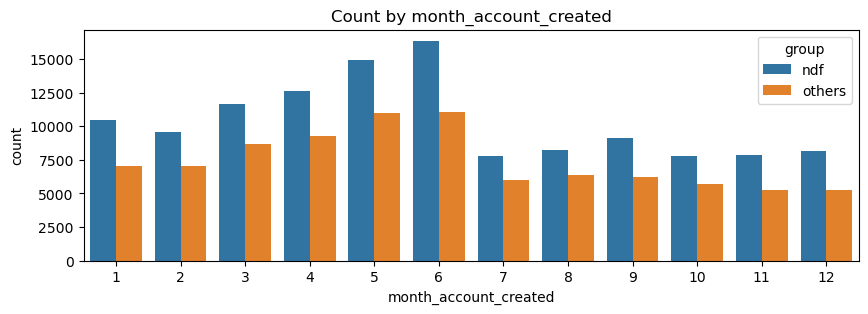

In [51]:
temporal_barplot('month_account_created')

### day of week

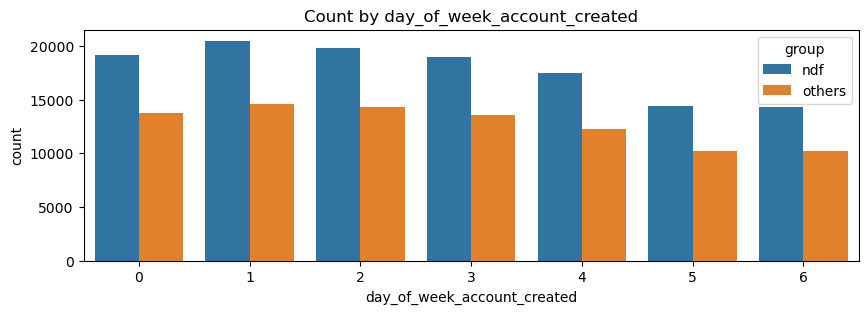

In [52]:
temporal_barplot('day_of_week_account_created')

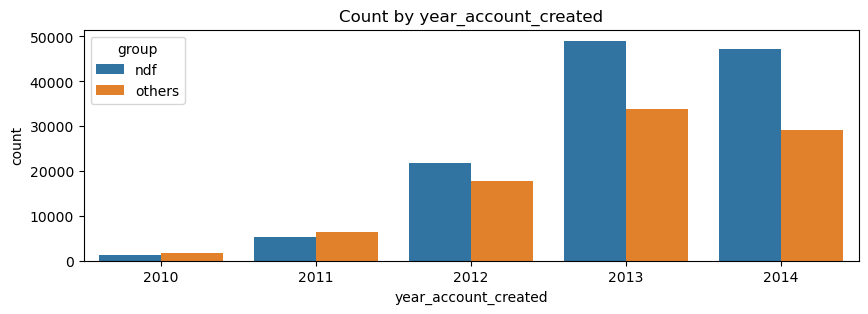

In [53]:
temporal_barplot('year_account_created')

### Análise temporal

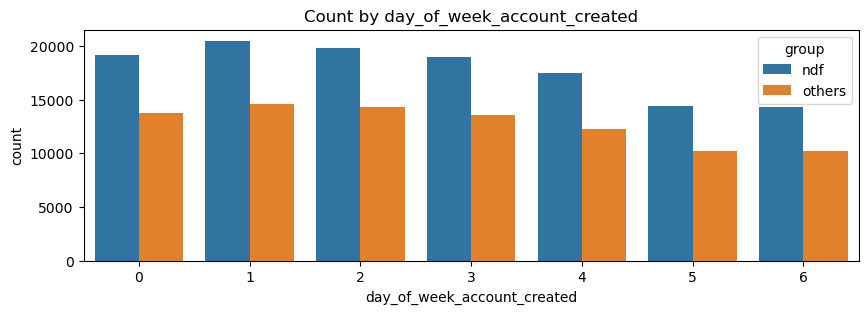

In [54]:
temporal_barplot('day_of_week_account_created')

In [57]:
df['signup_flow'].value_counts()

0     164739
25     14659
12      9329
3       8822
2       6881
24      4328
23      2835
1       1047
6        301
8        240
21       196
5         36
20        14
16        11
15        10
10         2
4          1
Name: signup_flow, dtype: int64

In [58]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
